I begin by importing everything necessary for the program to function


In [1]:
%%bash

pip install hmmlearn
pip install biopython
pip install gffutils
wget --quiet https://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/S288C_reference_genome_Current_Release.tgz
tar -xzvf S288C_reference_genome_Current_Release.tgz
mv S288C_reference_genome_R64-2-1_20150113 data
rm S288C_reference_genome_Current_Release.tgz

  Created wheel for gffutils: filename=gffutils-0.10.1-cp36-none-any.whl size=1608578 sha256=1d81e125f3b21e96c03a5e7dc3aa96f56153181d5d45a77166846185fd68d769
  Stored in directory: /root/.cache/pip/wheels/52/c8/8c/5b5edef863b51b00f822fd7783608ea7a09b4ab75b87226479
  Created wheel for pyfaidx: filename=pyfaidx-0.5.8-cp36-none-any.whl size=25051 sha256=1954d01d3e1f5456deed4a114b5b897019a37bcbec66427f3fea2349be786c67
  Stored in directory: /root/.cache/pip/wheels/58/ea/ee/59d4649b0fb82a0690bdeae834bc85891b306126bcc067e29f
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114215 sha256=30d1f9b12f5f9c30072af3e9f890b5a4aa2fa34d253fc2b944c166c54c472c06
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built gffutils pyfaidx simplejson
S288C_reference_genome_R64-2-1_20150113/
S288C_reference_genome_R64-2-1_20150113/rna_coding_R64-2-1_20150113.fasta
S288C_reference_genome_R64-2-1_2015

In [0]:
# then i continue with your code for diffent aspects of the program

# Python built-ins
import re
import time

# Installed packages
import numpy as np
from hmmlearn import hmm
from Bio import SeqIO


def translate_symbol_sequence_to_numbers(symbol_sequence: str, symbol_alphabet: list) -> list:
    """
    Translate emission symbols to numbers so that the HMM model can work with them
    """
    translation_table = {symbol_alphabet[i]: i 
                         for i in range(len(symbol_alphabet))}
    return [translation_table[symbol] for symbol in symbol_sequence]


def translate_numbers_to_symbol_sequence(number_sequence: list, symbol_alphabet: list) -> str:
    """
    Translate HMM hidden state numbers into symbols
    """
    symbols = [symbol_alphabet[x] for x in number_sequence]
    return ''.join(symbols)


def get_gene_start_and_stop_from_annotation(annotation: str, gene_pattern: str) -> list:
    """
    Return a list of (start_pos, end_pos) pairs for found genes.

    Needs a regular expression (gene_pattern) that describes what a gene looks like
    in terms of hidden states.
    
    Example:   
        gene_pattern = 'C+'   # a sequence which consists of at least one C
        annotation = 'NNCCNCCN'
        
        returns [(2, 4), (5, 7)]
    """
    gene_positions = []
    for match in re.finditer(gene_pattern, annotation):
        gene_positions.append(match.span())
    return gene_positions


def translate_genes(gene_positions: list, dna_sequence) -> list:
    aa_sequences = []
    for gene_pos in gene_positions:
        aa = dna_sequence[gene_pos[0] : gene_pos[1]].transcribe().translate()
        aa_sequences.append(aa)
    return aa_sequences

#aa_sequences = translate_genes(gene_positions, ref_chromosomes[0].seq)

# Preview
#aa_sequences[0]
#str(aa_sequences[0])


## useful for plotting distribution of lengths
def plot_protein_length_distribution(aa_sequences: list):
    import pandas as pd
    pd.DataFrame({'gene length': map(lambda s: len(s), aa_sequences)}).hist(log=True)

#plot_protein_length_distribution(aa_sequences)


def read_protein_sequences_from_fasta(fasta_filename: str) -> list:
     return list(SeqIO.parse(fasta_filename, 'fasta'))

def save_sequences_as_fasta(sequences: list, fasta_filename: str):
    fasta_entries = []
    for i in range(len(sequences)):
        if len(sequences[i]) > 20:   # shortest known protein in any organism
            fasta_entries.append(f'>gene{i}\n{sequences[i]}\n')
    with open(fasta_filename, 'w') as output_fasta:
        output_fasta.writelines(fasta_entries)
    print(f'INFO: Wrote {len(fasta_entries)} protein sequences')   


## Next: Prepare training data and load reference genome

`hmmlearn` wants training sequences to be columns in a matrix. So here we structure the chromosome sequences that way, also converting from symbolic to numeric representation.  Details: https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences

In [3]:
ref_chromosomes = list(SeqIO.parse('data/S288C_reference_sequence_R64-2-1_20150113.fsa', 'fasta'))
print(ref_chromosomes[16]) #https://biopython.org/wiki/SeqIO   # there are 17 chromosomes!
#print(len(test_data))
#print(trainig_lengths)

#print(basic_model.transmat_)
#print(basic_model.startprob_)
#print(basic_model.tol)


ID: ref|NC_001224|
Name: ref|NC_001224|
Description: ref|NC_001224| [org=Saccharomyces cerevisiae] [strain=S288C] [moltype=genomic] [location=mitochondrion] [top=circular]
Number of features: 0
Seq('TTCATAATTAATTTTTTATATATATATTATATTATAATATTAATTTATATTATA...ATA', SingleLetterAlphabet())


# Next, my work!
I experimented with tweaking the number of iterations. It seems that going up from 10 to maybe 30 makes a huge difference for the end result in terms of length distributions, but later it only starts taking a lot of time to do the computation. This indicates the algorith I use, "Viterbi" converges somewhere between 10 and 30 iterations in my case. This should depend on the initial guess and number of training chromosomes though, and I only tested this when running on 2 chromosomesdue to the computation time for more chromosomes!

In [5]:
# MY WORK! Model based on 3 codon positions, introns and intergenic regions

# in this setting, a gene region is when it is not in state N! 
hidden_states = ['1','2','3','N','I']        # Called "components" in this package # I is intron region, N is intergenic region, number is codon position 1 2 or 3
emission_labels = ['A','C','G','T']   # Called "features"
MAX_N_BAUM_WELCH_ITERATIONS = 30   # HERE ONE CAN CHANGE!

# Create model object
basic_model = hmm.MultinomialHMM(n_components = len(hidden_states), # number of states
                                 n_iter = MAX_N_BAUM_WELCH_ITERATIONS,
                                 init_params="") # maybe i dont want to guess the emissionprobabilities, if so, just type in "e"

# Adjust its parameters
basic_model.n_features = len(emission_labels)

# Order of elements must match those in the component and features lists above
basic_model.startprob_ = np.array([0, 0, 0, 1, 0])    # much more likely to start on a noncoding sequence, in fact guaranteed!

basic_model.transmat_ = np.array([[0, 1, 0    , 0    , 0   ], #while in 1, can nonly go to 2
                                  [0, 0, 1 , 0, 0   ], # while in 2, can only get to 3
                                  [0.992, 0,    0, 0.002, 0.006 ], # while in 3, most likely to get back to first part of codon C1, intron not so unlikely
                                  [0.002,0,    0, 0.998, 0    ], #while in intergenic region N, can only go to N or C1 how long is the average intergenic region? here i guess about thousand!
                                  [0.0025, 0,    0, 0, 0.9975    ]]) # while in intron, most likely to end up in intron or C1, impossible to end up in intergenic region


                         # ABOUT INTRON LENGTH, approx 100 from figure 6  in     http://ribonode.ucsc.edu/Pubs/Spingolaetal99.pdf 

# The matrix is expected to be of shape (rows=states x cols=emissions), therefore, we should transpose it with .T of we type it out as below wehre columns are states
# Here it's transposed from the form used in lecture slides
basic_model.emissionprob_ = np.array([[0.26, 0.3, 0.17, 0.27,0.26  ],    # I should base these on codon bias!
                                      [0.26, 0.24, 0.32, 0.23, 0.22],  # based on the papers, very random in my opinion! https://www.math.uwaterloo.ca/~aghodsib/courses/w05stat440/w05stat440-notes/feb27.pdf
                                      [0.32, 0.2, 0.31, 0.23, 0.22],
                                      [0.16, 0.26, 0.20, 0.27,0.3 ]]).T


print(basic_model.transmat_)
#print(basic_model.init_params)
#print(basic_model.params)

 
# Maybe use the AATAAA sequence to get the end of a gene! like after AATA call something a "end_of_gene_exon" which is highly likely to terminate, e.g has high probabilities for 
# TAG, TAG, TGA.  If we find sucha a sequnence, it is likely at end of some gene. However, complement may be in beginning of gene if on reverse strand,
# consider also intergenic regions with stuff like promoters.

[[0.     1.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.    ]
 [0.992  0.     0.     0.002  0.006 ]
 [0.002  0.     0.     0.998  0.    ]
 [0.0025 0.     0.     0.     0.9975]]


## Define the training set, 
Here one has to alter the code if wanting to run on many chromosomes or just a few!
I tested to run on all 17 and show one such result later on, but most ofthen i only used one or 2 for training due to the time it takes (approx 20000 seconds) to train on all chromosomes!




In [0]:
# Include k chromosomes in training data
training_chromosome_idx= [0,2]  # chromosme 0 and 2
#training_chromosome_idx = list(range(0,17))  ## TRAINING ON ALL CHROMOSOMES, this has length 12157105 from len(trainig data)

trainig_data = np.concatenate(
    [np.array(
        translate_symbol_sequence_to_numbers(ref_chromosomes[k].seq, emission_labels)
        ).reshape(-1, 1)  # makes it a column vector
     for k in training_chromosome_idx]
)

trainig_lengths = [len(ref_chromosomes[k].seq) for k in training_chromosome_idx]

# Test on chromosome 1
test_data = np.array(
    [translate_symbol_sequence_to_numbers(ref_chromosomes[0].seq, emission_labels)]
).T

## Do the actual training computation!


In [27]:
 #here is the training! doing i

t0 = time.time()    # this is just to measure execution time (nothing to do with hmmlearn)
np.random.seed(41)  # Make this randomized procedure deterministic (reproducible) 41 is my preferred one

basic_model.fit(trainig_data, trainig_lengths)

print(f'Training took {time.time() - t0} seconds')


Training took 119.75500249862671 seconds


## Annotate chromosome

Use the trained model to annotate our test chromosome with 1,2,3, I or N (codon positions 1,2,3 , Intron or Noncoding(intergenic)). The `.predict()` function is used.

[0. 0. 0. 1. 0.]  startprobabilities
[[0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.97880878 0.         0.         0.01715424 0.00403698]
 [0.0221271  0.         0.         0.9778729  0.        ]
 [0.00287701 0.         0.         0.         0.99712299]]  transition matrix/probabilities
[[0.29269868 0.19193098 0.21256524 0.3028051 ]
 [0.28332057 0.15396073 0.23495203 0.32776667]
 [0.20923489 0.31522647 0.1533688  0.32216983]
 [0.42677178 0.16733057 0.22349992 0.18239773]
 [0.34163532 0.15852935 0.15964229 0.34019304]]  emission probabilities
The number of annotated genes are  484


/usr/local/lib/python3.6/dist-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


<class 'list'>


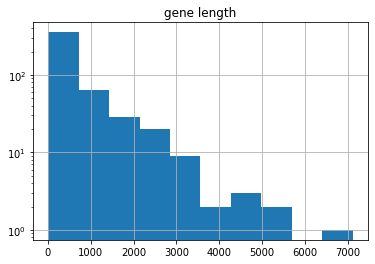

In [16]:
# some check to study adequacy, differnece to initial values
print(basic_model.startprob_, " startprobabilities")
print(basic_model.transmat_, " transition matrix/probabilities")
print(basic_model.emissionprob_, " emission probabilities" )
# Test on chromosome 1
test_data = np.array(
    [translate_symbol_sequence_to_numbers(ref_chromosomes[12].seq, emission_labels)]
).T

annotation_numeric = basic_model.predict(test_data)  # numbers == hidden state number
annotation = translate_numbers_to_symbol_sequence(annotation_numeric, hidden_states)
gene_positions = get_gene_start_and_stop_from_annotation(annotation, 
                                                         gene_pattern = '[^N]+')  # this works! string of no Noncoding(intergenic) are interpreted as single genes
# Preview gene positions
#print(gene_positions) # gives indices of where it starts!
# also get where there arent genes!
#non_gene_positions=get_gene_start_and_stop_from_annotation(annotation, gene_pattern = '[N]+')

print("The number of annotated genes are ", len(gene_positions)) # this gives the number of genes!

aa_sequences = translate_genes(gene_positions, ref_chromosomes[12].seq)  # basd on the results we have got!
plot_protein_length_distribution(aa_sequences)
print(type(aa_sequences))

## Procedure to compare with augustus

I have to import the augustus reference annotation file first:

I have named it _ref_annot_augustus.aa_ on my laptop, so this is what I upload.

 


In [12]:
from google.colab import files
# use the file ref_annot_augustus.aa
uploaded = files.upload()
def read_protein_sequences_from_fasta(fasta_filename: str) -> list:
     return list(SeqIO.parse(fasta_filename, 'fasta'))



Saving ref_annot_augustus.aa to ref_annot_augustus.aa


number of proteins estimated by augustus = 5465


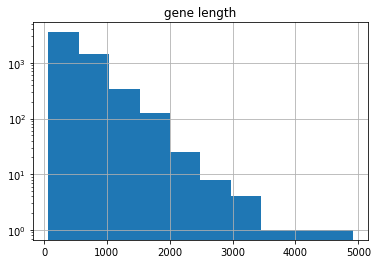

In [14]:
augustus_protein_sequences=read_protein_sequences_from_fasta("ref_annot_augustus.aa")  
plot_protein_length_distribution(augustus_protein_sequences)
# notice since we here have the entire genome, the absolute counts are much higher than for only ONE chromosome
print("number of proteins estimated by augustus =", len(augustus_protein_sequences)) #gives 5465 aka  the number of genes found, a number also backed up on ncbi https://www.ncbi.nlm.nih.gov/pubmed/11967832

# Comments and conclusions on this exercise

## Deciding on the model, choosing initial probabilities and some flaws
I created a fairly simple HMM based on three codon positions, introns and intergenic regions. The idea was that it is not allowed to move from codon poistion 1 to anything but codon 2. At codon 3 one can enter intergenic, codon 1, intron or noncoding. from intron one can only enter codon 1 etc.. This model is flawed partly because I only take into account one direction of encoded genes, (although they may be on any of the 2 strands) and also don't care about e.g stop codons being the only ones allowed to end a gene. However, it is slightly more complex than the simple noncoding-coding version and I decided to use it. It can be improved e.g by including start and stop codons and allowing introns to span triplets, e.g allow an intron so start in codon position 1 iff i then ends so that the next base is a codon position 2 base. Nevertheless, I will now try to justify my choices of initial probabilities shown above in the code for my model.

To get reasonable __transition probabilities__ apart from the trivial zeros, I searched the web for stuff like average intron lengths et cetera. for example this article shows in figure 6 a distribution of intron lengths centered around 400. This could be approxiamtely achieved by setting the transitions to 0.9975 for intron to intron as the expected length of the intron sequence would then be 1/(1-0.9975)=400. A similar argument was made for the intergenic regions, that I believe should be around 100-1000 bp long.

For the __emission probabilities__ I presumed there would be readily available information about codon bias for certain bases, but did not manage to find a reliable source. Therefore, I chose to compared the performance of using that referenced in  https://www.math.uwaterloo.ca/~aghodsib/courses/w05stat440/w05stat440-notes/feb27.pdf on slide 16 with simply making a random assignment of emission probabilities! It turned out that the random assignment was less successful with respect to getting a gene distribution simlar to augustus, so i used the ones in the article, althoug they themsolves do not justify their choices. 

Regarding the __start_probabilities__ it is obvoius that the start must be noncoding, thus all but one were set to zero! 

## Training results
My main metric for successful training was similarity to augustus distribution of gene lengths. 
I tried with different numbers of iterations and seeds. 
Regarding the __seeds__, I did notice that the results are very dependent on this parameter, which indicates the solution is very unstable, in a sense that small changes how to stochastically assign things yields highly varaible results, something undesirable. However, I only checked this for training on fewer chromosomes due to time constrains. Maybe when training on more data the solution is less volatile. Ayways, it is highly indicative that I am not likely to have found any global optima, which is of course a tradeoff when using viterbi or most greedy algorithms, that we simply have to accept.

Above was a simple model based on training on only two chromosomes, and the length distribution was deceptively similar to Augustus when looking at a single chromosome to validate the model.
However, using the script below to annotate all chromosomes one quickly sees that, although the number of genes is similar to that of Augustus( approx 6000 depending on the seed compared to 5465 with Augustus), there are plenty of unreasonably too long genes.


/usr/local/lib/python3.6/dist-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


 number of genes = 6231


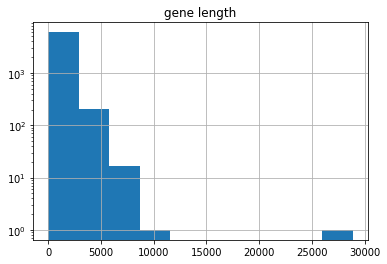

In [18]:
# this is to study all chromosomes as test data!

ref_chromo=''
for i in range(0,17): 
    ref_chromo+=ref_chromosomes[i].seq
test_data = np.array(
    [translate_symbol_sequence_to_numbers(ref_chromo, emission_labels)]
).T

annotation_numeric = basic_model.predict(test_data)  # numbers == hidden state number
annotation = translate_numbers_to_symbol_sequence(annotation_numeric, hidden_states)
gene_positions = get_gene_start_and_stop_from_annotation(annotation, 
                                                        gene_pattern = '[^N]+')  # this works! string of no Noncoding(intergenic) are interpreted as single genes

aa_sequences = translate_genes(gene_positions, ref_chromo)  # basd on the results we have got!
plot_protein_length_distribution(aa_sequences)
print(" number of genes =", len(gene_positions))   # note, I have aproximately the same number of genes as augustus

## Continuing on training results with more models
Clearly, training on only 2 chromosomes, regardless of the volatility in choosing different random seeds, is insufficient, but how about a more extensive training?
In this repository,  have stored some different resulting models in pickle format, I will begin to examine one where I trained on 14 chromosomes in 10 iterations. 
First, one has to import it using `files.upload()` and then `with open("filename.pkl", "rb") as file: modelname=pickle.load(file)`


In [25]:
files.upload()

Saving iter_30_17_chromosomes.pkl to iter_30_17_chromosomes.pkl


{'iter_30_17_chromosomes.pkl': b'\x80\x03chmmlearn.hmm\nMultinomialHMM\nq\x00)\x81q\x01}q\x02(X\x0c\x00\x00\x00n_componentsq\x03K\x05X\x06\x00\x00\x00paramsq\x04X\x03\x00\x00\x00steq\x05X\x0b\x00\x00\x00init_paramsq\x06X\x00\x00\x00\x00q\x07X\x0f\x00\x00\x00startprob_priorq\x08G?\xf0\x00\x00\x00\x00\x00\x00X\x0e\x00\x00\x00transmat_priorq\tG?\xf0\x00\x00\x00\x00\x00\x00X\t\x00\x00\x00algorithmq\nX\x07\x00\x00\x00viterbiq\x0bX\x0c\x00\x00\x00random_stateq\x0ccnumpy.random._pickle\n__randomstate_ctor\nq\rX\x07\x00\x00\x00MT19937q\x0e\x85q\x0fRq\x10}q\x11(X\r\x00\x00\x00bit_generatorq\x12h\x0eX\x05\x00\x00\x00stateq\x13}q\x14(X\x03\x00\x00\x00keyq\x15cnumpy.core.multiarray\n_reconstruct\nq\x16cnumpy\nndarray\nq\x17K\x00\x85q\x18C\x01bq\x19\x87q\x1aRq\x1b(K\x01Mp\x02\x85q\x1ccnumpy\ndtype\nq\x1dX\x02\x00\x00\x00u4q\x1eK\x00K\x01\x87q\x1fRq (K\x03X\x01\x00\x00\x00<q!NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tq"b\x89B\xc0\t\x00\x00)\x00\x00\x00.\x015M\x8d\x9e\xd4\xafn\x15\xa6\xd1\x05\xc9\xf8

/usr/local/lib/python3.6/dist-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


 Number of genes = 3078


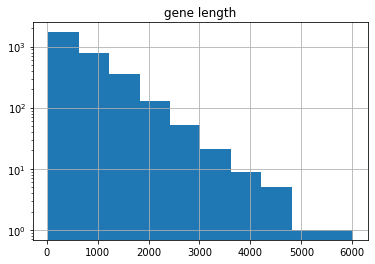

In [24]:
## SAVING MODELS AND bringing them back. below is comented aut code for saving and downloading resulting models to local
#import pickle
#with open("iter_30_17_chromosomes.pkl", "wb") as file: pickle.dump(basic_model, file)
#files.download("iter_30_17_chromosomes.pkl")

# here's how to bring a model into python, based on havnig uploaded it to the directory.
import pickle
with open("14chrom10itermod.pkl", "rb") as file: model_14_10=pickle.load(file) 
annotation_numeric = model_14_10.predict(test_data)  
annotation = translate_numbers_to_symbol_sequence(annotation_numeric, hidden_states)
gene_positions = get_gene_start_and_stop_from_annotation(annotation, 
                                                        gene_pattern = '[^N]+') 

aa_sequences = translate_genes(gene_positions, ref_chromo)  #
plot_protein_length_distribution(aa_sequences)
print(" Number of genes =", len(gene_positions))   # note, I have aproximately the same number of genes as augustus


Clearly, this model seems better at avoiding the crazy high gene lengths, although we now severly under estimate the total number of genes, at approximately 3000 compared to approx 5500 from NCBI or Augustus. 
So, does including all chromosomes in the training make things even better?
Lets check that using a model based on all of them, where I also threw in an extra 20 iterations for good measure.

/usr/local/lib/python3.6/dist-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


 Number of genes = 2090


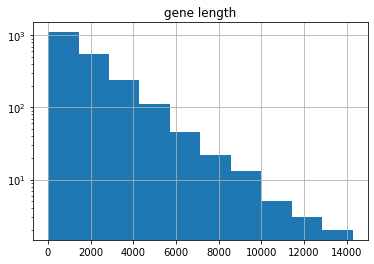

In [26]:
import pickle
with open("iter_30_17_chromosomes.pkl", "rb") as file: model_17_30=pickle.load(file) 
annotation_numeric = model_17_30.predict(test_data)  
annotation = translate_numbers_to_symbol_sequence(annotation_numeric, hidden_states)
gene_positions = get_gene_start_and_stop_from_annotation(annotation, 
                                                        gene_pattern = '[^N]+') 

aa_sequences = translate_genes(gene_positions, ref_chromo)  #
plot_protein_length_distribution(aa_sequences)
print(" Number of genes =", len(gene_positions))   # note, I have aproximately the same number of genes as augustus

NO, the model did not become better, sadly. It worse in a sense that we are back to getting huge gene length predictions and much to few genes in total. So, what does this tell us since one could assume that having more training data should lead to a better model? 

Well, this is highly dependent on having a sufficinetly good model as well, as one can never model reality if the assumptions made are simply too poor, which is apparently the case using this implistic model. 

However, my model did outperform the very basic 2 state model, at least if we consider the 14 chromosome trained model ! 


## Concluding remarks
I wanted to compare wih augustus in a more rigorous way, for example blast some of the reasonably sized putative proteins found against augususes, but due to the workload I simply did not have the time.

The main conclusions to be drawn is that the final model is very dependent both on the random seed, number of iterations and training data but also on the starting probabilities.
Tweaking the starting values slightly gives huge differences in results, and thus one way to improve this or any other model is to try ans assign biological meaning to the starting values prior to fitting, since this will assist the learning algorithm greatly.

 




In [0]:
#with open("iter_30_2_chromosomes.pkl", "wb") as file: pickle.dump(basic_model, file)
#files.download("iter_30_2_chromosomes.pkl")